In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [2]:
train_data = pd.read_csv("/content/drive/MyDrive/Project/yelp_review_train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Project/yelp_review_test.csv")

train_data.head(), test_data.head()

(                                                text  stars
 0  Went for lunch and found that my burger was me...    2.0
 1  I needed a new tires for my wife's car. They h...    5.0
 2  Jim Woltman who works at Goleta Honda is 5 sta...    5.0
 3  Been here a few times to get some shrimp.  The...    4.0
 4  This is one fantastic place to eat whether you...    5.0,
                                                 text  stars
 0  Hidden treasure! Awesome service, delicious fo...    5.0
 1  My family and I have been patients since I  wa...    5.0
 2  I rarely get pedicures, but Blue Nail's practi...    5.0
 3  We came with a large group, may of the items w...    2.0
 4  The view is great from Morgan's Pier. The bart...    2.0)

In [3]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Function to clean and preprocess the text
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Apply the preprocessing function to the text column of both datasets
train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

# Function to convert stars to sentiment labels
def convert_stars_to_sentiment(stars):
    if stars > 3:
        return 'Positive'
    elif stars == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Apply the conversion function to the stars column of both datasets
train_data['sentiment'] = train_data['stars'].apply(convert_stars_to_sentiment)
test_data['sentiment'] = test_data['stars'].apply(convert_stars_to_sentiment)

# Drop the original stars column
train_data.drop('stars', axis=1, inplace=True)
test_data.drop('stars', axis=1, inplace=True)

# Display the first few rows of the processed training data
train_data.head(), test_data.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(                                                text sentiment
 0  went lunch found burger meh obvious focus burg...  Negative
 1  needed new tires wifes car special order next ...  Positive
 2  jim woltman works goleta honda 5 stars knowled...  Positive
 3  times get shrimp theyve got nice selection dif...  Positive
 4  one fantastic place eat whether hungry need go...  Positive,
                                                 text sentiment
 0  hidden treasure awesome service delicious food...  Positive
 1  family patients since 5 years old 34 trust qua...  Positive
 2  rarely get pedicures blue nails practice combi...  Positive
 3  came large group may items missing menu lobste...  Negative
 4  view great morgans pier bartenders even good s...  Negative)

In [4]:
# Define the mapping
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

# Apply the mapping to the sentiment columns
train_data['sentiment'] = train_data['sentiment'].map(label_mapping)
test_data['sentiment'] = test_data['sentiment'].map(label_mapping)

# Check for any unmapped or NaN values in the sentiment column
print("Unmapped values in training data:", train_data[train_data['sentiment'].isna()])
print("Unmapped values in test data:", test_data[test_data['sentiment'].isna()])

train_data.head()



Unmapped values in training data: Empty DataFrame
Columns: [text, sentiment]
Index: []
Unmapped values in test data: Empty DataFrame
Columns: [text, sentiment]
Index: []


,text,sentiment
0,went lunch found burger meh obvious focus burg...,0
1,needed new tires wifes car special order next ...,2
2,jim woltman works goleta honda 5 stars knowled...,2
3,times get shrimp theyve got nice selection dif...,2
4,one fantastic place eat whether hungry need go...,2


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set the fixed length for reviews
fixed_length = 150

# Initialize and fit the tokenizer on the training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

# Convert the text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

# Pad the sequences so that they all have the same length
train_padded = pad_sequences(train_sequences, maxlen=fixed_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=fixed_length, padding='post', truncating='post')

# Checking the shape of the padded sequences
train_padded.shape, test_padded.shape


((174757, 150), (13980, 150))

In [39]:
from sklearn.model_selection import train_test_split
# Splitting the data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data['text'], train_data['sentiment'], test_size=0.2, random_state=42)

In [40]:
from tensorflow.keras.utils import to_categorical

test_labels = to_categorical(test_data['sentiment'], num_classes=3)
#test_labels = to_categorical(test_labels, num_classes=3)
train_labels = to_categorical(train_labels, num_classes=3)
val_labels = to_categorical(val_labels, num_classes=3)

train_texts.shape, val_texts.shape, train_labels.shape, val_labels.shape, test_labels.shape

((139805,), (34952,), (139805, 3), (34952, 3), (13980, 3))

In [33]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint

# Load pre-trained BERT model and tokenizer
bert_model = TFBertModel.from_pretrained('bert-base-uncased', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=150)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=150)
test_encodings = tokenizer(test_data['text'].tolist(), truncation=True, padding=True, max_length=150)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_data['sentiment'].values
)).batch(32)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


4369/4369 [==============================] - ETA: 0s - loss: 0.8097 - accuracy: 0.6761

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4369/4369 [==============================] - 1512s 339ms/step - loss: 0.8097 - accuracy: 0.6761 - val_loss: 0.6841 - val_accuracy: 0.7511
Epoch 2/3
4369/4369 [==============================] - 1475s 338ms/step - loss: 0.6494 - accuracy: 0.7731 - val_loss: 0.5198 - val_accuracy: 0.8198
Epoch 3/3
4369/4369 [==============================] - 1475s 338ms/step - loss: 0.5370 - accuracy: 0.8200 - val_loss: 0.4599 - val_accuracy: 0.8333


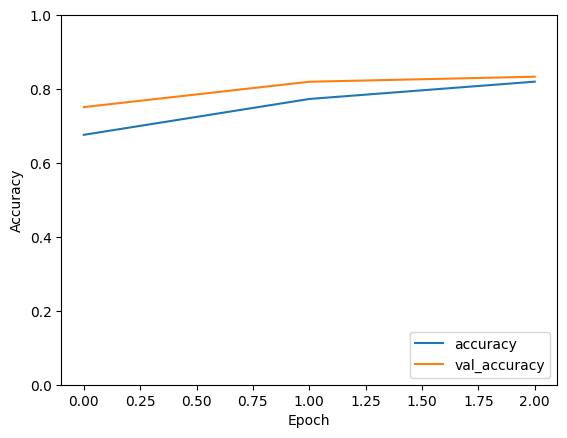

In [23]:
# Define a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-5,
    decay_steps=10000,
    decay_rate=0.9)

# Build a custom model
input_ids = tf.keras.layers.Input(shape=(150,), dtype='int32', name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(150,), dtype='int32', name='attention_mask')

# Extract hidden states from BERT
hidden_states = bert_model(input_ids, attention_mask=attention_mask)[0]

# Custom layers on top of BERT
x = tf.keras.layers.GlobalAveragePooling1D()(hidden_states)  # Average pooling
x = tf.keras.layers.Dense(64, activation='relu')(x)  # Dense layer
x = tf.keras.layers.Dropout(0.5)(x)  # Dropout for regularization
output = tf.keras.layers.Dense(3, activation='softmax')(x)  # Final classification layer

# Compile the model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb = ModelCheckpoint("bert_yelp_reviews.h5", save_best_only=True)
history = model.fit(train_dataset, epochs=3, validation_data=val_dataset, callbacks=[checkpoint_cb])
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

## Sentiment Analysis Model Training

### Learning Rate Schedule
A learning rate schedule was defined using an exponential decay, which starts at an initial learning rate of `5e-5` and decays every `10,000` steps with a rate of `0.9`. This approach helps in controlling the learning speed of the model, allowing for larger updates to the weights at the beginning, and smaller updates as training progresses.

### Model Architecture
The model is built on top of the pre-trained BERT (`bert-base-uncased`) model with the following custom layers:
- **Global Average Pooling 1D**: Condenses the output tensor of the BERT model by taking the average across the sequence dimension, reducing the tensor from three dimensions to two.
- **Dense Layer**: A dense layer with 64 units and ReLU activation function is used to introduce non-linearity and aid in learning complex patterns.
- **Dropout**: A dropout layer with a rate of `0.5` is included to prevent overfitting by randomly setting input units to `0` at each step during training time, which helps to prevent overfitting.
- **Output Layer**: The final layer is a dense layer with 3 units and a softmax activation function to output the probabilities of the three sentiment classes (negative, neutral, positive).

### Model Compilation
The model is compiled with the SGD optimizer, which is configured with the previously defined learning rate schedule, and uses `categorical_crossentropy` as the loss function due to the nature of the classification problem. The accuracy metric is monitored during training.

### Model Checkpointing
A `ModelCheckpoint` callback is used to save the best model based on validation accuracy, ensuring that the best performing model is retained.

### Training
The model is trained for 3 epochs on the `train_dataset`, with the `val_dataset` used for validation. The training process is visualized by plotting the training and validation accuracy over epochs, demonstrating an increase in accuracy and a decrease in loss over time, indicating that the model is learning effectively.



In [41]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(32)


In [42]:
from transformers import TFBertForSequenceClassification

# Custom object needed for keras to understand the BERT model
custom_objects = {
    'TFBertForSequenceClassification': TFBertForSequenceClassification,
    'TFBertModel': TFBertModel
}


# Load the saved model with custom object
best_model = tf.keras.models.load_model("bert_yelp_reviews.h5", custom_objects=custom_objects)

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


437/437 [==============================] - 54s 116ms/step - loss: 0.4640 - accuracy: 0.8306
Test Loss: 0.4639679491519928
Test Accuracy: 0.8306151628494263


## Test Set Performance Analysis

After fine-tuning the pre-trained BERT model (`bert-base-uncased`) with custom layers and training on a sentiment analysis task using the Yelp Reviews dataset, the model's performance was evaluated on an unseen test set. The following results were obtained:

- **Test Loss**: The model achieved a test loss of `0.4640`, which is relatively low and suggests that the model has learned to generalize well from the training data.
- **Test Accuracy**: An accuracy of `83.06%` on the test set indicates that the model is able to correctly predict the sentiment of a review with high reliability.

This performance is a strong indication that the model has not only learned the patterns present in the training data but is also able to effectively apply this knowledge to new, unseen data. The relatively close performance metrics between the validation set during training and the test set suggest that the model has not overfit to the training data and confirms its generalization capability.

### Conclusion

The fine-tuned BERT model demonstrates promising results, achieving over `83%` accuracy in classifying the sentiment of Yelp reviews. The test loss and accuracy metrics indicate that the model can serve as a robust tool for sentiment analysis tasks in similar contexts.
